# CIFAR-10

<img src='materials/cifar-10_labels.png'>

https://www.cs.toronto.edu/~kriz/cifar.html

CIFAR-10 dataset은 32x32로 이루어진 color 이미지 60000장을 수록하고 있는 dataset입니다.<br>
category의 개수는 10개로, 각 category 마다 6000장의 image가 존재합니다. <br>
50000장의 image를 training data로, 10000장의 image를 test data로 제공합니다.

### CIFAR-10 데이터 받기

In [1]:
import math
import timeit
import matplotlib.pyplot as plt
import os
from six.moves import urllib
import sys, tarfile, glob
import shutil
%matplotlib inline

data_path = '../datasets'
if not os.path.exists(data_path):
    os.makedirs(data_path)

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
file_name = url.split('/')[-1]
u = urllib.request.urlopen(url)
file_meta = u.info()
file_size = int(file_meta["Content-Length"])

def printProgress(current, total, prefix='Progress', suffix='Complete', barLength=100):
    percent = (current)*100 / float(total)
    assert current <= total  and percent >= 0, "Invaild total and current %d %d %d" %(current, total, percent)
    progressed = int(percent * barLength / 100)
    bar = '#' * progressed + '-' * (barLength-progressed)
    sys.stdout.write('\r%s |%s| %3.2f %s %s'%(prefix, bar, percent, '%', suffix))
    if current == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
file_path = os.path.join(data_path,file_name)
if not os.path.exists(file_path) or os.stat(file_path).st_size != file_size:
    f = open(file_path, 'wb')
    print ("Downloading: %s Bytes: %s" % (file_path, file_size))
    file_size_dl = 0
    file_block_sz = 1024 * 64
    while True:
        buffer = u.read(file_block_sz)
        if not buffer:
               break
        file_size_dl += len(buffer)
        f.write(buffer)
        printProgress(file_size_dl, file_size)
    f.close()

f = tarfile.open(file_path)
f.extractall(data_path)
f.close()

In [2]:
import platform
from six.moves import cPickle as pickle
import numpy as np

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(data_path='.'):
    
    ROOT = data_path+'/datasets/cifar-10-batches-py'
    
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [3]:
train_data, train_label, test_data, test_label = load_CIFAR10('..')
train_data = train_data/255.
test_data = test_data/255.

## CIFAR-10 데이터 확인하기

In [4]:
CIFAR10_LABELS_LIST = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
print (train_data.shape)
print (train_label.shape)
print (test_data.shape)
print (test_label.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


ship


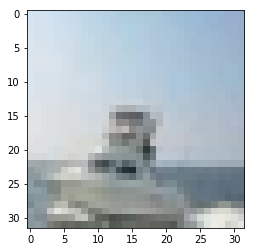

In [5]:
# show data
_, ax = plt.subplots()
sample_data = train_data[100]
print(CIFAR10_LABELS_LIST[train_label[100]])
ax.imshow(sample_data);


# Data Pre-processing (데이터 전처리)

In [6]:
import tensorflow as tf
import random
import shutil

SUMMARY_DIR = './summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)

def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)
    
    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label

def get_one_hot(label):
    """
    get one hot encoded label matrix

    Args:
        label: original label

    Returns:
        One hot encoded label matrix
    """
    # Make 0 initialized numpy array with shape of [label.shape[0], 10]
    one_hot = np.zeros((label.shape[0], 10))
    # Fill up the array according to the input label
    one_hot[np.arange(label.shape[0]), label.astype(int)] = 1
    return one_hot

## Loss function (손실 함수) : Cross Entropy

# <center> \\( L(y_i, f(x_i; W)) = -\frac{1}{n}\sum_{i=1}^{n} y_{i} log(f(x_i))\\)</center>

In [7]:
def get_cross_entropy_loss(y_true, y_hat, epsilon=1e-8):
    """
    compute cross entropy

    Args:
        y_true: true label
        y_hat: predicted label
        epsilon: small value to prevent NaN in log

    Returns:
        cross entropy loss
    """
    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_hat + epsilon), axis=1), name='cross_entropy')
    return cross_entropy

def get_accuracy(y_true, y_hat):
    """
    accuracy 구하기

    Args:
        y_true: true label
        y_hat: predicted label
    Returns:
        Accuracy
    
    Hints
        - tf.equal : 값을 비교하여 동일하면 1, 다르면 0을 return
        - tf.argmax : 값이 최대인 위치의 index를 return
        - tf.cast : data type을 변경하는 함수
        - tf.reduce_mean : 지정한 축(axis)에 대해 평균을 취하는 함수.
    """
    with tf.name_scope('accuracy'):
        # Compare the highest indices between the predicted label and the true label
        correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y_true, 1), name='correct_prediction')
        # Compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

## Hyper-parameter (하이퍼 파라미터)

In [8]:
# Set hypyerparameters
learning_rate = 1e-4
max_iter = 30000
batch_size = 100

## Linear Classifier (선형 분류기)

## <center> \\( f(x) = xW+b \\)</center>

In [9]:
def fully_connected(inputs, out_dim, name):
    """
    Args :
        Inputs : Input tensor
        out_dim : output dimension
        name : name for parameter
    Returns:
        output
    Hints
        - tf.Variable : name을 다르게 주면 각 variable의 이름이 다르게 설정되도록 해야합니다.
        - tf.matmul : matrix 연산을 수행하는 함수
    """
    with tf.name_scope('fully_connected'+str(name)):
        # Get dimension of inputs (not batch)
        in_dim = inputs.get_shape().as_list()[1]
        # initializer for weight matrix -> tf.zeros([])
        W = tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=0.01), name='weights')
        # initializer for bias vector -> tf.zeros([])
        b = tf.Variable(tf.zeros([out_dim]), name='biases')
        # compute logits
        output = tf.matmul(inputs, W) + b
    return output


# Implementation (4)

## Making Model.

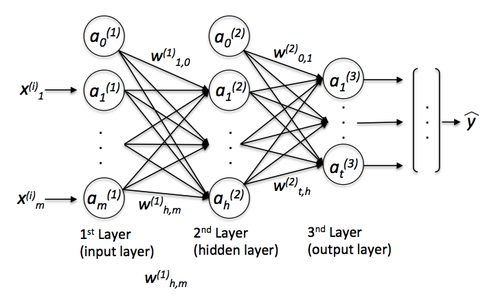
1st, 2nd layer의 unit의 갯수가 128인 layer 3개의 neural network를 구축하세요.

In [10]:
def model(Inputs, keep_prob):
    """
    Args :
        Inputs : Input tensor
        hidden : output dimension of hidden layer
        out_dim : output dimension of output layer
        keep_prob : probability of DropOut
    Return :
        y_logits
    Hint
        - tf.tanh, tf.nn.relu, tf.nn.sigmoid : 대표적인 activation 함수
        - tf.nn.dropout : dropout
    """
    
    
    # First fully connected layer
    h = fully_connected(Inputs, 256,1)
    # add non-linearity (using tf.nn.relu(input))
    h_tanh = tf.tanh(h)
    # add dropout (using tf.nn.dropout(input, probability))
    h_drop = tf.nn.dropout(h_tanh, keep_prob)
    # Second fully connected layer
    h = fully_connected(h_drop, 256,2)
    # add non-linearity (using tf.nn.relu(input))
    h_tanh = tf.tanh(h)
    y_logits = fully_connected(h_tanh, 10,3)
    return y_logits

In [11]:
tf.reset_default_graph()

# ---------------------------------------------------------------------------------------------------------
# 1) Data Flatting
# Batch 단위의 데이터를 다루기 때문에 하나의 sample은 [1 x D] 의 형태로 만들어주는 것이 처리하기 편함.
# Hint : np.reshape or reshape
# ---------------------------------------------------------------------------------------------------------
train_data = train_data.reshape(-1, 32*32*3)
test_data = test_data.reshape(-1, 32*32*3)

# ---------------------------------------------------------------------------------------------------------
# 2) Convert label to one hot vector
# 0 ~ 10으로 이루어진 label을 각각 10차원의 vector로 해당하는 category의 index만을 1로 가지는 vector로 변환
# Hint : 위에서 선언한 함수를 참조
# ---------------------------------------------------------------------------------------------------------
train_label_hot = get_one_hot(train_label)
test_label_hot = get_one_hot(test_label)

# ---------------------------------------------------------------------------------------------------------
# 3) Declare Placeholders
# input, true_label, dropout을 위한 placeholder 선언
# Hint : tf.placeholder, input과 ouput이 어떤 차원을 가져야할지 고민해봅시다.
# ---------------------------------------------------------------------------------------------------------
x = tf.placeholder(tf.float32, [None, 32*32*3])
keep_prob = tf.placeholder(tf.float32)
y_true = tf.placeholder(tf.float32, [None, 10])

# ---------------------------------------------------------------------------------------------------------
# 4) model declare & normalization
# logits을 얻기 위해 기존의 정의한 model을 사용하고, 이를 softmax를 통해 정규화하여 classification을 수행합니다.
# Hint : tf.nn.softmax
# ---------------------------------------------------------------------------------------------------------
y_logits = model(x, keep_prob)
y_hat = tf.nn.softmax(y_logits, name='y_hat')

# ---------------------------------------------------------------------------------------------------------
# 5) obtain loss & accuracy
# 앞서 정의한 function들을 통해 loss와 accuracy를 얻습니다.
# ---------------------------------------------------------------------------------------------------------
cross_entropy = get_cross_entropy_loss(y_true, y_hat)
accuracy = get_accuracy(y_true, y_hat)

# ---------------------------------------------------------------------------------------------------------
# 6) Optimizer
# Parameter Update를 위한 Optimizer를 선언합니다.
# Hint : tf.train.GradientDescentOptimizer, tf.train.AdamOptimizer
# ---------------------------------------------------------------------------------------------------------
# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [12]:
# ---------------------------------------------------------------------------------------------------------
# 7) Session 
# tensorflow의 연산을 수행하기 위해 session을 호출합니다.
# ---------------------------------------------------------------------------------------------------------
sess= tf.Session()

# ---------------------------------------------------------------------------------------------------------
# 8) variable iniializer 
# tensorflow의 variable들을 초기화 하기 위해 initializer를 사용합니다.
# Hint : tf.global_variables_initializer
# ---------------------------------------------------------------------------------------------------------
sess.run(tf.global_variables_initializer())
# ---------------------------------------------------------------------------------------------------------
# 9) training 
# ---------------------------------------------------------------------------------------------------------
for step in range(max_iter):
    # Get batch data and label
    batch_x, batch_y = get_next_batch(train_data, train_label_hot, batch_size)
    # train the network and calculate cross entropy
    _, loss = sess.run([train_step, cross_entropy], feed_dict={x: batch_x, y_true:batch_y,
                                                               keep_prob: 0.5})
    if (step + 1) % 1000 == 0:
        acc= sess.run(accuracy, feed_dict={x: test_data, y_true: test_label_hot, keep_prob: 1.0})
        print("{}th iteration, loss: {:.4f}, test accuracy: {:.4f}".format(step + 1, loss, acc))

1000th iteration, loss: 1.7614, test accuracy: 0.3529
2000th iteration, loss: 1.8239, test accuracy: 0.3836
3000th iteration, loss: 1.8936, test accuracy: 0.4049
4000th iteration, loss: 1.6212, test accuracy: 0.4191
5000th iteration, loss: 1.7073, test accuracy: 0.4372
6000th iteration, loss: 1.7814, test accuracy: 0.4349
7000th iteration, loss: 1.6133, test accuracy: 0.4440
8000th iteration, loss: 1.6246, test accuracy: 0.4525
9000th iteration, loss: 1.5670, test accuracy: 0.4551
10000th iteration, loss: 1.5257, test accuracy: 0.4505
11000th iteration, loss: 1.4270, test accuracy: 0.4698
12000th iteration, loss: 1.5555, test accuracy: 0.4772
13000th iteration, loss: 1.6337, test accuracy: 0.4807
14000th iteration, loss: 1.4385, test accuracy: 0.4821
15000th iteration, loss: 1.5769, test accuracy: 0.4861
16000th iteration, loss: 1.6709, test accuracy: 0.4869
17000th iteration, loss: 1.3211, test accuracy: 0.4903
18000th iteration, loss: 1.3992, test accuracy: 0.4951
19000th iteration, 

In [13]:
# ---------------------------------------------------------------------------------------------------------
# 10) test 결과 수집 
# test 결과를 확인하기 위해 label prediction 결과를 저장합니다.
# ---------------------------------------------------------------------------------------------------------
y_pred = sess.run(y_hat, feed_dict={x:test_data, keep_prob:1.0})
sess.close()

('pr', ['cat', 'truck', 'ship', 'airplane', 'deer'])
('gt', ['cat', 'ship', 'ship', 'airplane', 'frog'])


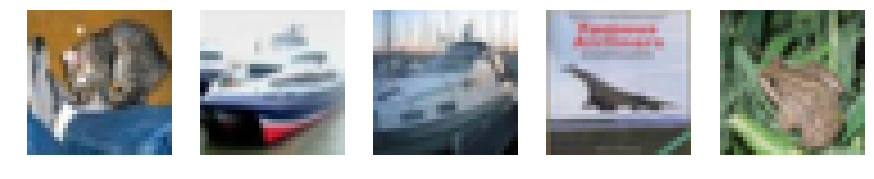

('pr', ['frog', 'cat', 'frog', 'bird', 'automobile'])
('gt', ['frog', 'automobile', 'frog', 'cat', 'automobile'])


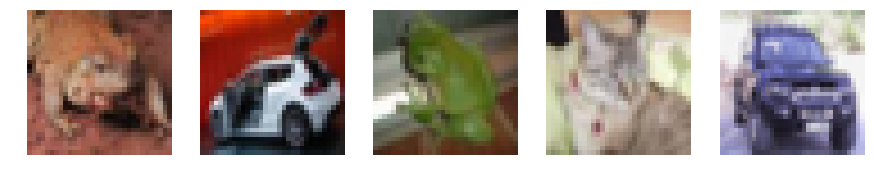

('pr', ['airplane', 'truck', 'dog', 'horse', 'automobile'])
('gt', ['airplane', 'truck', 'dog', 'horse', 'truck'])


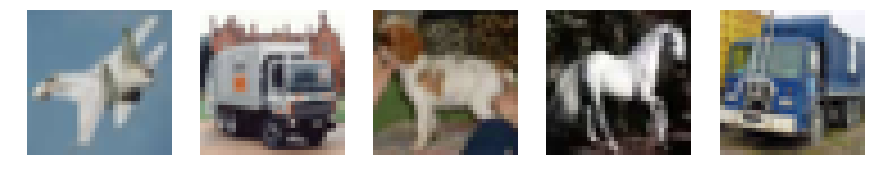

('pr', ['ship', 'dog', 'cat', 'ship', 'frog'])
('gt', ['ship', 'dog', 'horse', 'ship', 'frog'])


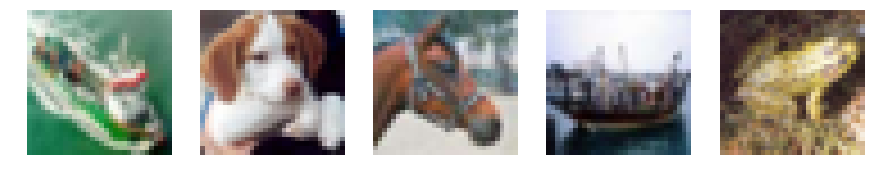

('pr', ['deer', 'bird', 'airplane', 'truck', 'deer'])
('gt', ['horse', 'airplane', 'deer', 'truck', 'dog'])


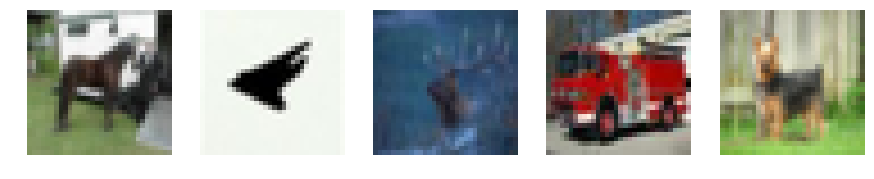

In [14]:
for j in range(5):
    f, ax = plt.subplots(1,5,figsize=(15, 15))
    pred, g_t = [], []
    for i in range(5):
        pred.append(CIFAR10_LABELS_LIST[np.argmax(y_pred[5*j+i])])
        g_t.append(CIFAR10_LABELS_LIST[np.argmax(test_label_hot[5*j+i])])
        ax[i].imshow(test_data[5*j+i].reshape(32,32,3))
        ax[i].axis('off')
    print("pr", pred)
    print("gt", g_t)
    plt.show()

<img src="materials/pD0hWu5.gif" alt="Drawing" style="width: 400px;"/>
<img src="materials/NKsFHJb.gif" alt="Drawing" style="width: 400px;"/>
<img src="materials/2dKCQHh.gif" alt="Drawing" style="width: 400px;"/>